### Analytics

In [219]:
import os, math
import pandas as pd
import numpy as np

# RDKit
import rdkit
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import PandasTools
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem.Draw import SimilarityMaps

# DeepChem
import deepchem as dc

# plotting
import seaborn as sns
import matplotlib.pyplot as plt

In [38]:
df = pd.read_csv("data/solubility-dataset.csv")

In [39]:
df.head()

,ID,Name,InChI,InChIKey,SMILES,Solubility,SD,Ocurrences,Group,MolWt,...,NumRotatableBonds,NumValenceElectrons,NumAromaticRings,NumSaturatedRings,NumAliphaticRings,RingCount,TPSA,LabuteASA,BalabanJ,BertzCT
0,A-3,"N,N,N-trimethyloctadecan-1-aminium bromide",InChI=1S/C21H46N.BrH/c1-5-6-7-8-9-10-11-12-13-...,SZEMGTQCPRNXEG-UHFFFAOYSA-M,[Br-].CCCCCCCCCCCCCCCCCC[N+](C)(C)C,-3.616127,0.0,1,G1,392.510,...,17.0,142.0,0.0,0.0,0.0,0.0,0.00,158.520601,0.000000e+00,210.377334
1,A-4,Benzo[cd]indol-2(1H)-one,InChI=1S/C11H7NO/c13-11-8-5-1-3-7-4-2-6-9(12-1...,GPYLCFQEKPUWLD-UHFFFAOYSA-N,O=C1Nc2cccc3cccc1c23,-3.254767,0.0,1,G1,169.183,...,0.0,62.0,2.0,0.0,1.0,3.0,29.10,75.183563,2.582996e+00,511.229248
2,A-5,4-chlorobenzaldehyde,InChI=1S/C7H5ClO/c8-7-3-1-6(5-9)2-4-7/h1-5H,AVPYQKSLYISFPO-UHFFFAOYSA-N,Clc1ccc(C=O)cc1,-2.177078,0.0,1,G1,140.569,...,1.0,46.0,1.0,0.0,0.0,1.0,17.07,58.261134,3.009782e+00,202.661065
3,A-8,"zinc bis[2-hydroxy-3,5-bis(1-phenylethyl)benzo...",InChI=1S/2C23H22O3.Zn/c2*1-15(17-9-5-3-6-10-17...,XTUPUYCJWKHGSW-UHFFFAOYSA-L,[Zn++].CC(c1ccccc1)c2cc(C(C)c3ccccc3)c(O)c(c2)...,-3.924409,0.0,1,G1,756.226,...,10.0,264.0,6.0,0.0,0.0,6.0,120.72,323.755434,2.322963e-07,1964.648666
4,A-9,4-({4-[bis(oxiran-2-ylmethyl)amino]phenyl}meth...,InChI=1S/C25H30N2O4/c1-5-20(26(10-22-14-28-22)...,FAUAZXVRLVIARB-UHFFFAOYSA-N,C1OC1CN(CC2CO2)c3ccc(Cc4ccc(cc4)N(CC5CO5)CC6CO...,-4.662065,0.0,1,G1,422.525,...,12.0,164.0,2.0,4.0,4.0,6.0,56.60,183.183268,1.084427e+00,769.899934


In [40]:
# Asssumption:
    # Soluble if logS > math.log10(200 * 1e-6)
# Binary variable: for classification based on aqueous solubility

df["isSoluble"] = (df.Solubility > math.log10(200*1e-6)).astype(int)

In [41]:
df.columns

Index(['ID', 'Name', 'InChI', 'InChIKey', 'SMILES', 'Solubility', 'SD',
       'Ocurrences', 'Group', 'MolWt', 'MolLogP', 'MolMR', 'HeavyAtomCount',
       'NumHAcceptors', 'NumHDonors', 'NumHeteroatoms', 'NumRotatableBonds',
       'NumValenceElectrons', 'NumAromaticRings', 'NumSaturatedRings',
       'NumAliphaticRings', 'RingCount', 'TPSA', 'LabuteASA', 'BalabanJ',
       'BertzCT', 'isSoluble'],
      dtype='object')

In [42]:
df.isSoluble.value_counts()

1    6713
0    3269
Name: isSoluble, dtype: int64

Is soluble: 1


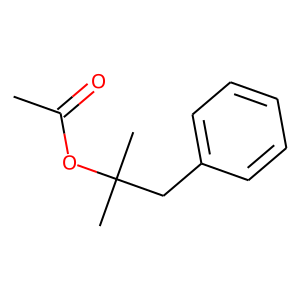

In [137]:
mol = Chem.MolFromSmiles(df.SMILES.values[11])
print(f"Is soluble: {df.isSoluble.values[11]}")
Draw.MolToImage(mol, wedgeBonds=False)

Is soluble: 1


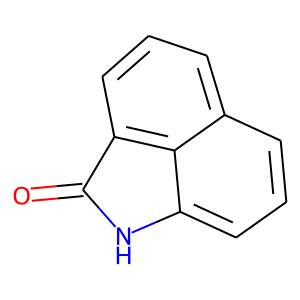

In [138]:
mol1 = Chem.MolFromSmiles(df.SMILES.values[1])
print(f"Is soluble: {df.isSoluble.values[5]}")
Draw.MolToImage(mol1, wedgeBonds=False)

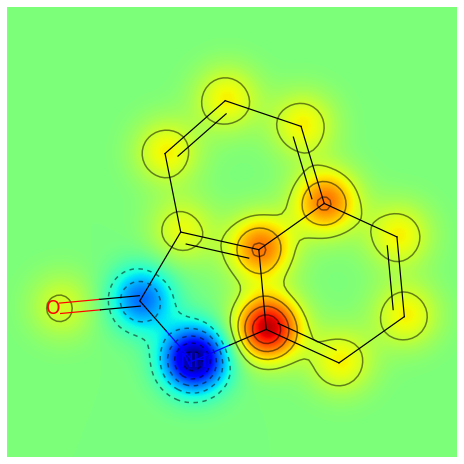

In [120]:
# Similarity Map
contribs = rdMolDescriptors._CalcCrippenContribs(mol1)
fig = SimilarityMaps.GetSimilarityMapFromWeights(mol1,[x for x,y in contribs], colorMap='jet', contourLines=10)

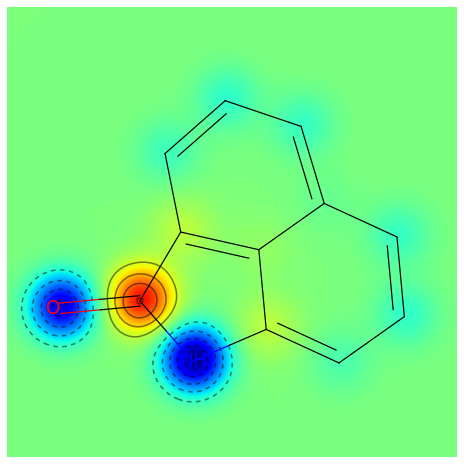

In [122]:
AllChem.ComputeGasteigerCharges(mol1)
contribs = [mol1.GetAtomWithIdx(i).GetDoubleProp('_GasteigerCharge') for i in range(mol1.GetNumAtoms())]
fig = SimilarityMaps.GetSimilarityMapFromWeights(mol1, contribs, colorMap='jet', contourLines=10)

### Grid plot and distributions based on different features

In [68]:
# Number of molecules 
N = 16

smiles_list = df.SMILES[np.random.randint(0, df.shape[0], N)].values
mols = [rdkit.Chem.MolFromSmiles(smi) for smi in smiles_list]

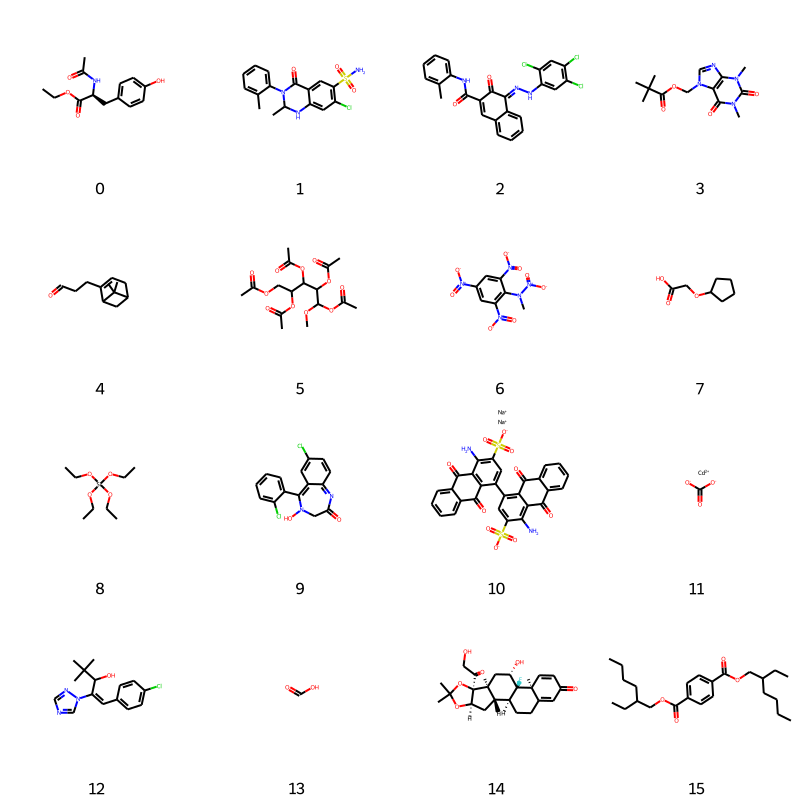

In [69]:
Draw.MolsToGridImage(mols, molsPerRow=4, legends=[str(i) for i in range(len(mols))])

In [82]:
df.columns

Index(['ID', 'Name', 'InChI', 'InChIKey', 'SMILES', 'Solubility', 'SD',
       'Ocurrences', 'Group', 'MolWt', 'MolLogP', 'MolMR', 'HeavyAtomCount',
       'NumHAcceptors', 'NumHDonors', 'NumHeteroatoms', 'NumRotatableBonds',
       'NumValenceElectrons', 'NumAromaticRings', 'NumSaturatedRings',
       'NumAliphaticRings', 'RingCount', 'TPSA', 'LabuteASA', 'BalabanJ',
       'BertzCT', 'isSoluble'],
      dtype='object')

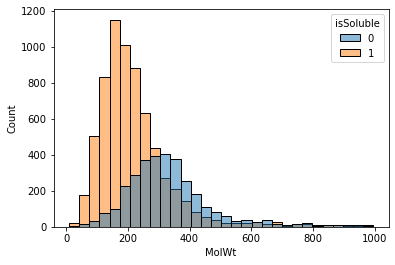

In [152]:
sns.histplot(x="MolWt", hue='isSoluble', data=df[df.MolWt < 1000], bins=30);

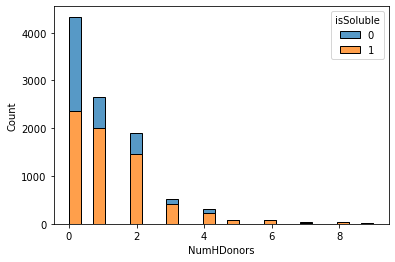

In [91]:
sns.histplot(x="NumHDonors", hue="isSoluble", data=df[df.NumHDonors < 10], bins=25, multiple="stack");

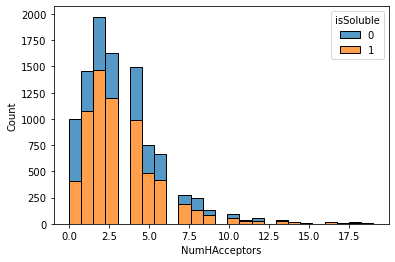

In [105]:
sns.histplot(x="NumHAcceptors", hue="isSoluble", data=df[df.NumHAcceptors < 20], bins=25, multiple="stack");

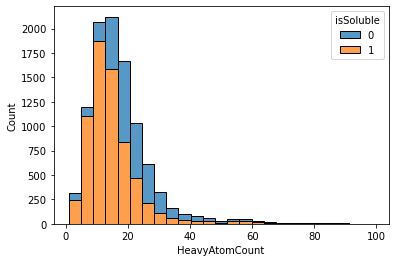

In [93]:
sns.histplot(x="HeavyAtomCount", hue="isSoluble", data=df[df.HeavyAtomCount < 100], bins=25, multiple="stack");

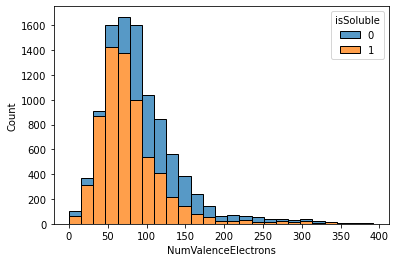

In [95]:
sns.histplot(x="NumValenceElectrons", hue="isSoluble", data=df[df.NumValenceElectrons < 400], bins=25, multiple="stack");

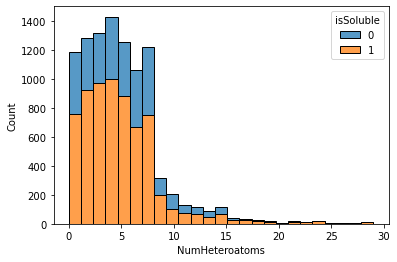

In [104]:
sns.histplot(x="NumHeteroatoms", hue="isSoluble", data=df[df.NumHeteroatoms < 30], bins=25, multiple="stack");

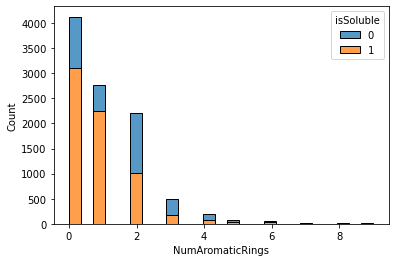

In [154]:
sns.histplot(x="NumAromaticRings", hue="isSoluble", data=df[df.NumAromaticRings < 10], bins=25, multiple="stack");

In [151]:
# Selecting a list of few molecules

In [78]:
dff = df[df.SMILES.isin(smiles_list)]

In [79]:
dff = dff[["ID", "SMILES", "Solubility", "Group", "MolWt", "isSoluble"]]
dff

,ID,SMILES,Solubility,Group,MolWt,isSoluble
311,A-519,CC1(C)C2CC=C(CCC=O)C1C2,-3.465761,G1,178.275,1
1061,A-1825,[Cd++].[O-]C([O-])=O,-2.179683,G1,172.420,1
2003,A-3301,OC=O,1.175855,G3,46.025,1
2068,A-3410,[Na+].[Na+].Nc1c2C(=O)c3ccccc3C(=O)c2c(cc1[S](...,-2.030180,G1,648.538,1
2770,A-4628,CCO[Si](OCC)(OCC)OCC,-2.145566,G1,208.330,1
3012,A-5045,ON1CC(=O)N=C2C=CC(=CC2=C1c3ccccc3Cl)Cl,-4.465333,G1,321.163,0
3384,A-5560,CCCCC(CC)COC(=O)c1ccc(cc1)C(=O)OCC(CC)CCCC,-8.989632,G1,390.564,0
3391,A-5583,Cc1ccccc1NC(=O)C2=Cc3ccccc3C(=N/Nc4cc(Cl)c(Cl)...,-7.694310,G1,484.770,0
3778,B-207,CC1(C)O[C@@H]2C[C@H]3[C@@H]4CCC5=CC(=O)C=C[C@]...,-4.315800,G1,434.504,0
4295,B-978,CN(c1c(cc(cc1[N+]([O-])=O)[N+]([O-])=O)[N+]([O...,-3.588900,G1,287.144,1


In [80]:
# Adding the Molecule to the dff
PandasTools.AddMoleculeColumnToFrame(dff, 'SMILES', 'Molecule', includeFingerprints=True)

,ID,SMILES,Solubility,Group,MolWt,isSoluble,Molecule
311,A-519,CC1(C)C2CC=C(CCC=O)C1C2,-3.465761,G1,178.275,1,
1061,A-1825,[Cd++].[O-]C([O-])=O,-2.179683,G1,172.420,1,
2003,A-3301,OC=O,1.175855,G3,46.025,1,
2068,A-3410,[Na+].[Na+].Nc1c2C(=O)c3ccccc3C(=O)c2c(cc1[S](...,-2.030180,G1,648.538,1,
2770,A-4628,CCO[Si](OCC)(OCC)OCC,-2.145566,G1,208.330,1,
3012,A-5045,ON1CC(=O)N=C2C=CC(=CC2=C1c3ccccc3Cl)Cl,-4.465333,G1,321.163,0,
3384,A-5560,CCCCC(CC)COC(=O)c1ccc(cc1)C(=O)OCC(CC)CCCC,-8.989632,G1,390.564,0,
3391,A-5583,Cc1ccccc1NC(=O)C2=Cc3ccccc3C(=N/Nc4cc(Cl)c(Cl)...,-7.694310,G1,484.770,0,
3778,B-207,CC1(C)O[C@@H]2C[C@H]3[C@@H]4CCC5=CC(=O)C=C[C@]...,-4.315800,G1,434.504,0,
4295,B-978,CN(c1c(cc(cc1[N+]([O-])=O)[N+]([O-])=O)[N+]([O...,-3.588900,G1,287.144,1,

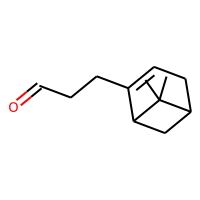
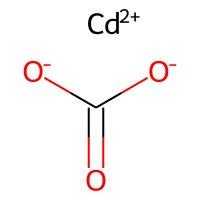
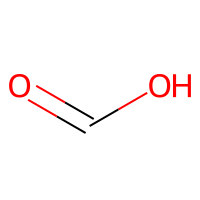
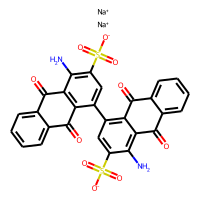
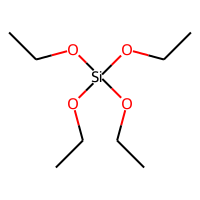
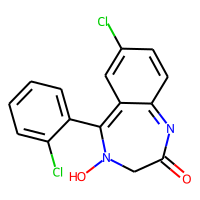
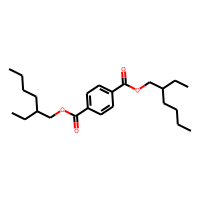
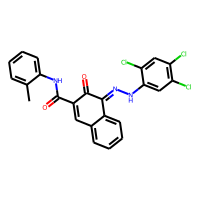
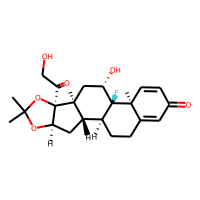
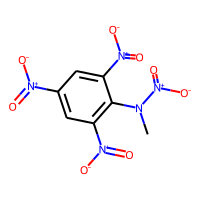
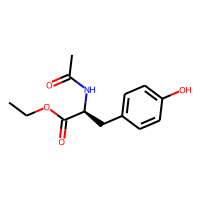
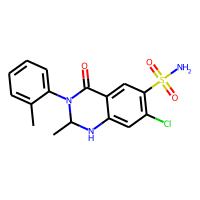
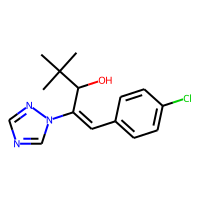
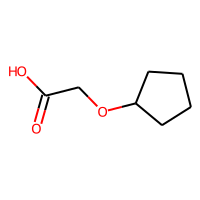
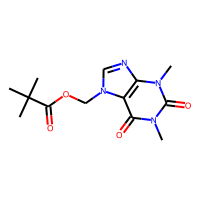
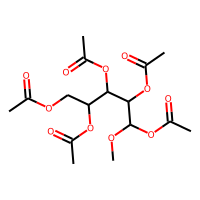

In [81]:
dff

In [218]:
# Done